**Libraries**

In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install Pillow
!pip install keras
!pip install opencv-python


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import os
import random
import collections
import seaborn as sns
import zipfile
import os
import pandas as pd
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

**Load Data**

In [ ]:
from google.colab import files
files.upload()
# upload kaggle.json here - upload yours
# this to work directly with kaggle data, without downloading, then uploading on drive

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d /content/data
!ls /content/data/chest_xray

chest_xray  __MACOSX  test  train  val


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# zip_path = "/content/drive/MyDrive/x-ray.zip"
# extract_path = "/content/chest_xray"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
print(os.listdir("/content/data/chest_xray/chest_xray"))


['.DS_Store', 'train', 'val', 'test']


**Pre Processing**

In [ ]:
from sklearn.model_selection import train_test_split

base_dir = "/content/data/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Total Numbers of Images in Train Folder:")
print("Normal:", len(os.listdir(os.path.join(train_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(train_dir, "PNEUMONIA"))))

print("Total Numbers of Images in Validation Folder:")
print("Normal:", len(os.listdir(os.path.join(val_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(val_dir, "PNEUMONIA"))))

print("Total Numbers of Images in Test Folder:")
print("Normal:", len(os.listdir(os.path.join(test_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(test_dir, "PNEUMONIA"))))

Total Numbers of Images in Train Folder:
Normal: 1342
Pneumonia: 3876
Total Numbers of Images in Validation Folder:
Normal: 9
Pneumonia: 9
Total Numbers of Images in Test Folder:
Normal: 234
Pneumonia: 390


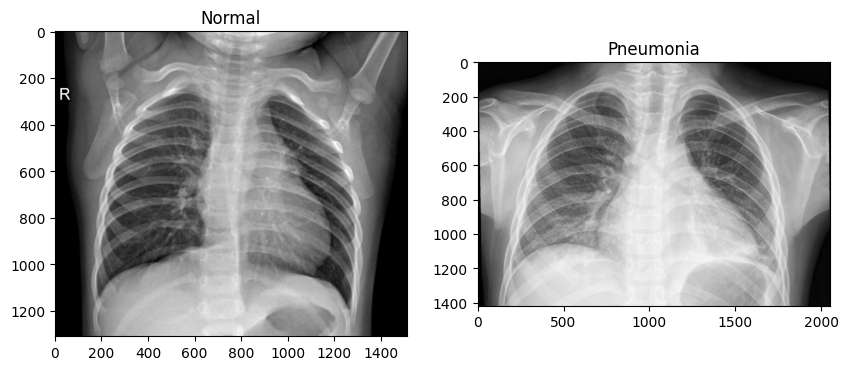

In [ ]:
normal_img = os.path.join(train_dir, "NORMAL", os.listdir(os.path.join(train_dir, "NORMAL"))[0])
pneumonia_img = os.path.join(train_dir, "PNEUMONIA", os.listdir(os.path.join(train_dir, "PNEUMONIA"))[0])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(mpimg.imread(normal_img), cmap='gray')
ax[0].set_title("Normal")
ax[1].imshow(mpimg.imread(pneumonia_img), cmap='gray')
ax[1].set_title("Pneumonia")
plt.show()


In [ ]:
!pip install split-folders

In [ ]:
import os
import shutil #For copying files between directories
import random
from sklearn.model_selection import train_test_split

original_dir = "/content/data/chest_xray/chest_xray/train"

# create a new directory in a drive, where the split dataset will be stored.
new_base_dir = "/content/newDataSet"
os.makedirs(new_base_dir, exist_ok=True)

# define 3 paths for 3 splits
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

# For each split, create subfolders to store images for NORMAL and PNEUMONIA.
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'PNEUMONIA'), exist_ok=True)

#copy_files: function copies a list of files from source_dir to dest_dir
def copy_files(files, source_dir, dest_dir):
    for f in files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))


for class_name in ['NORMAL', 'PNEUMONIA']:
    # lists and shuffles the image files to ensure randomness before splitting
    src_dir = os.path.join(original_dir, class_name)
    files = os.listdir(src_dir)
    random.shuffle(files)


    # Split into Train (70%), Validation (15%), and Test (15%)
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Moves the correctly split files into their respective class folders inside the train/val/test directories
    copy_files(train_files, src_dir, os.path.join(train_dir, class_name))
    copy_files(val_files, src_dir, os.path.join(val_dir, class_name))
    copy_files(test_files, src_dir, os.path.join(test_dir, class_name))

# Prints how many files each class has in a given split directory
def print_counts(dir_path):
    print(f"\n{dir_path}:")
    print("NORMAL:", len(os.listdir(os.path.join(dir_path, "NORMAL"))))
    print("PNEUMONIA:", len(os.listdir(os.path.join(dir_path, "PNEUMONIA"))))

print_counts(train_dir)
print_counts(val_dir)
print_counts(test_dir)



/content/newDataSet/train:
NORMAL: 939
PNEUMONIA: 2713

/content/newDataSet/val:
NORMAL: 201
PNEUMONIA: 581

/content/newDataSet/test:
NORMAL: 202
PNEUMONIA: 582


In [ ]:
from sklearn.model_selection import train_test_split

new_base_dir = "/content/newDataSet"
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

print("Total Numbers of Images in Train Folder:")
print("Normal:", len(os.listdir(os.path.join(train_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(train_dir, "PNEUMONIA"))))

print("Total Numbers of Images in Validation Folder:")
print("Normal:", len(os.listdir(os.path.join(val_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(val_dir, "PNEUMONIA"))))

print("Total Numbers of Images in Test Folder:")
print("Normal:", len(os.listdir(os.path.join(test_dir, "NORMAL"))))
print("Pneumonia:", len(os.listdir(os.path.join(test_dir, "PNEUMONIA"))))

Total Numbers of Images in Train Folder:
Normal: 939
Pneumonia: 2713
Total Numbers of Images in Validation Folder:
Normal: 201
Pneumonia: 581
Total Numbers of Images in Test Folder:
Normal: 202
Pneumonia: 582


Train Distribution:


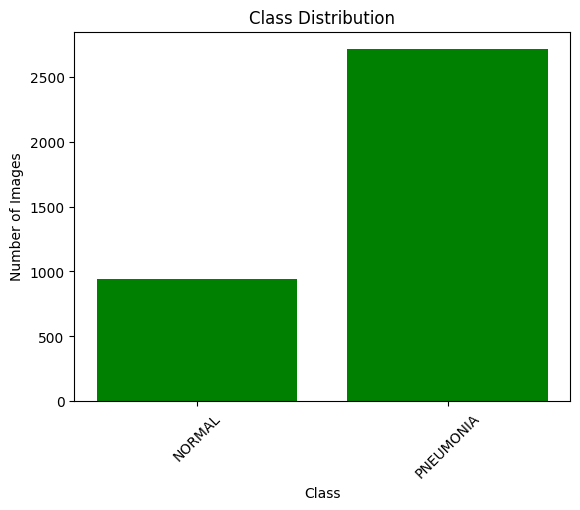

In [ ]:
def plot_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.bar(class_counts.keys(), class_counts.values(), color='green')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

print("Train Distribution:")
plot_class_distribution('/content/newDataSet/train')




In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
    )

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
    )

test_datagen = ImageDataGenerator(rescale=1./255)

testing_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False)

Found 3650 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 784 images belonging to 2 classes.


In [ ]:
# Imports the class_weight utility to compute weights inversely proportional to class frequencies.
from sklearn.utils import class_weight

# Automatically assigns higher weights to underrepresented classes
class_weights = class_weight.compute_class_weight(
    # Ensures weights are inversely proportional to class frequencies
    'balanced',
    # Gets the unique class labels (e.g., [0, 1] for NORMAL and PNEUMONIA).
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.9456289978678039), 1: np.float64(0.6729351032448377)}


**Build Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
     metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')])

# Monitors validation loss. If val loss doesn’t improve for 13 epochs, it reduces the learning rate by half. Ensures LR doesn’t fall below 1e-6
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=13,
    verbose=1,
    min_lr=1e-6
 )

checkpoint_path = "best_model_Version_1.weights.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=True

)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint,lr_reduce],
     class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.7373 - auc: 0.7937 - loss: 1.5600 - precision: 0.8901 - recall: 0.7344
Epoch 1: val_accuracy improved from -inf to 0.87596, saving model to best_model_Version_1.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 122s 916ms/step - accuracy: 0.7379 - auc: 0.7944 - loss: 1.5531 - precision: 0.8904 - recall: 0.7350 - val_accuracy: 0.8760 - val_auc: 0.9670 - val_loss: 0.2847 - val_precision: 0.9764 - val_recall: 0.8537 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8814 - auc: 0.9563 - loss: 0.2646 - precision: 0.9704 - recall: 0.8658
Epoch 2: val_accuracy improved from 0.87596 to 0.89258, saving model to best_model_Version_1.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 93s 811ms/step - accuracy: 0.8815 - auc: 0.9564 - loss: 0.2644 - precision: 0.9704 - recall: 0.8660 - val_accuracy: 0.8926 - val_auc: 0.9821 - val_loss: 0.2506 - val_precision: 0.9901 - val_recall: 0.8640 - learning_rate: 0.0010


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files

model.load_weights("best_model_Version_1.weights.h5")

model.save("best_model_full(x_ray).h5")


In [ ]:
train_eval = model.evaluate(train_generator)
val_eval = model.evaluate(validation_generator)
test_eval = model.evaluate(testing_generator)

train_accu = train_eval[1]
val_accu = val_eval[1]
test_accu = test_eval[1]

print("Final train accuracy = {:.2f}%, validation accuracy = {:.2f}%, testing accuracy = {:.2f}%"
      .format(train_accu * 100, val_accu * 100, test_accu * 100))


115/115 ━━━━━━━━━━━━━━━━━━━━ 77s 669ms/step - accuracy: 0.9913 - auc: 0.9996 - loss: 0.0243 - precision: 0.9993 - recall: 0.9890
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 635ms/step - accuracy: 0.9822 - auc: 0.9977 - loss: 0.0575 - precision: 0.9974 - recall: 0.9787
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.9747 - auc: 0.7672 - loss: 0.0753 - precision: 0.7692 - recall: 0.7242
Final train accuracy = 98.90%, validation accuracy = 98.34%, testing accuracy = 95.66%


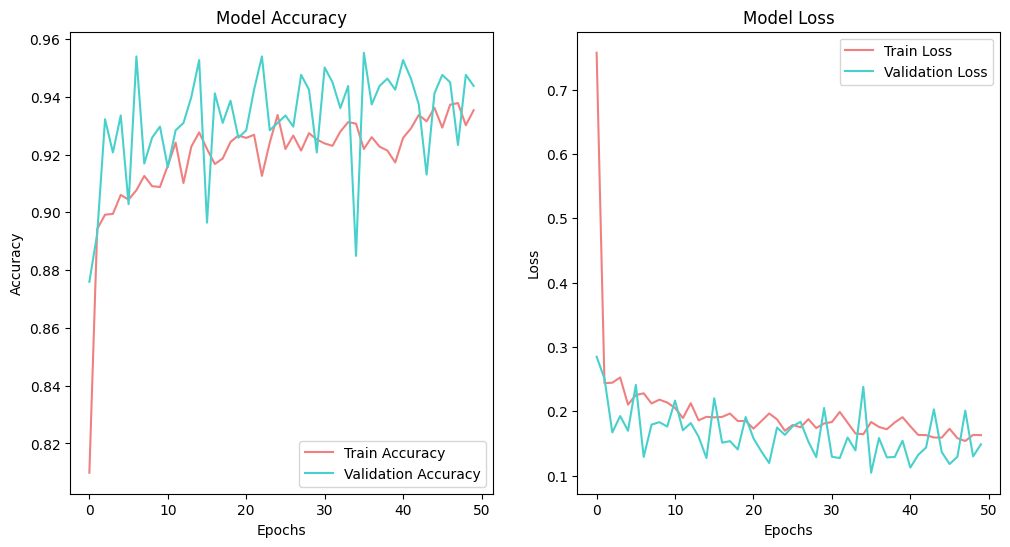

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='lightcoral')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='mediumturquoise')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='lightcoral')
plt.plot(history.history['val_loss'], label='Validation Loss', color='mediumturquoise')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()




plt.show()